**Engy-5050** Reactor Physics, UMass Lowell, Chem. Eng. Nuclear Program Spring 2022; Prof. V. F. de Almeida

# 1-D Point Source Neutron Transport
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers, Andrew Hamel <br>
**Course:** Engy-5050 Reactor Physics  <br>


UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**7March2022**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [FEM Approach](#app)
 + [Analytical Solution](#analyticalsol)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
    - [One-Group Energy](#onegroupenergy)
    - [Two-Group Energy](#twogroupenergy)
* [FDM Approach](#appFDM)
 + [Discretization](#setupFDM)
    - [One-Group Energy](#onegroupenergyFDM)
    - [Two-Group Energy](#twogroupenergyFDM)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

## [Problem Statement](#toc)<a id="problem"></a>

This investigation looks to determine how Finite Element Method (FEM) computation of the neutron diffusion equation compare to that of the Finite Difference Method (FDM) computation given standard assumptions about the definition of the diffusion coefficient in homogenous mediums far from and close to voids. Defining diffusion coefficients for neutron transport is an active field of research and includes approximations such as isotropic scattering, linear in angle, nonlocal weighting of nearby average transport properties, Monte Carlo study and experiment.

Here we will compare the analytic linear transport result for non-absorbing and moderately absorbing mediums given a point source in spherical geometry. As well as, comaprison of the two computational methods of FEM and FDM. 

For a monoenergetic group time independent neutron diffusion equation (NDE) in written assuming azimuthal symmetry as

Compute $\Phi_g:[r_\text{i},r_\text{o}]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
  \nabla \cdot D_g \nabla \Phi_g(r) - \Sigma_{g,r} \Phi_g(r) + S_{g'\rightarrow g} &= 0 \\
   q_{n,g}(r_\text{i}) &= A_g, \\
   q_{n,g}(r_\text{o}) &= \frac{\alpha}{2}\Phi_g(r_\text{o}).
\end{align*}

where the source term $S_{g'\rightarrow g} := \sum_{g'=1}^{G} \int_\Omega \Sigma_{s,g'\rightarrow g}\, f_{s,g'\rightarrow g}(\mu)\,d\Omega$ is the group down-scattering contribution for each group $g$.

The neutron scalar flux is: $\Phi(r)\ [n/cm^2 s]$ 

The total macroscopic cross section is: $\Sigma_{tot} = \Sigma_{non-el} + \Sigma_{el} \approx \Sigma_{abs} + \Sigma_{el}$

And the removal cross section for the multi group cross section is $ \Sigma_{r} = \Sigma_{tot} - \bar{\mu}\Sigma_{s} $

For brevity, $S' = Q^{fis}_{ext} + Q^{sc}_{in}$, is written as the combined source for exterior sources and fission sources or scatter in from out of group (up and down scatter). The full _scatter in term_ requires a _group averaged scatter cross section_ that further requires a _transfer function_ differential in post collision direction $\Omega \cdot \Omega '$. 

Here for the free surface (vacuum) boundary condition. The neutron density at the outer boundary $\Phi(r) = |v| n(r) = 0$ if $ n_b\cdot \Omega < 0 $.

### Domain
The domain utilized in the simulation is spherical geometry containt a point source. Surronding the point source is light-water.

## [FEM Approach](#toc)<a id="app"></a>

### [Analytic Solution](#toc)<a id="analyticalsol"></a> 

A general solution is commonly given without the asymptotic condition as:

\begin{align*}
    \Phi(r) =  \frac{S_0 e^{-\kappa r}}{4\pi Dr} \ \ \ (2)
\end{align*}



### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

The Galerkin weak formulation of the [strong form](#strongform) is as follows. Find $\Phi_g \in H^1\!\bigl([r_\text{i},r_\text{o}]\bigr)$ and $u_2 \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
\int\limits_a^b D\, u_1'(x)\,w'(x)\,dx - \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
  \int\limits_a^b v\, u_2'(x)\, w(x)\,dx + \int\limits_a^b D\, u_2'(x)\,w'(x)\,dx + \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $u_1$, $u_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

1. Multiply NDE by a test function $\phi$.
2. Integrate over spatial and angular domain.
3. Use divergence theorem to set the boundary condition across the domain surface.

The weak form and boundary condition becomes:

\begin{align*}
    ( \nabla \phi, D \nabla \Phi  )\ - < \phi, D \nabla \Phi \cdot \bar{n_b} > +\ (\phi , \Sigma_{tot} \Phi) = 0 \ \ \ (1B)
\end{align*}

This weak form contains the volume and surface integral as written with parenthesis and brackets respectively. The boundary conditions for the partial currents at the surface given as $\Gamma^{\pm}$ must be solved for:

\begin{align*}
    \Gamma^{+} = J^{out}({R_S}) = \nabla \Phi \cdot \bar{n_b}
\end{align*}

\begin{align*}
    \Gamma^{-} = J^{in}({R_S}) = 0
\end{align*}

Here we will use the homogenous Neumann boundary condition, which is equivalent to the Robin Vacuum boundary condition such that the reflectivity at the boundary is 0 as:

\begin{align*}
    \frac{1}{4} \Phi + \frac{1}{2} D \nabla \Phi \cdot \bar{n_b} = J^{-} = \frac{\Phi}{4} - \frac{J}{2} = \frac{\Phi}{4} - \frac{D \nabla \Phi}{2}
\end{align*}

Solving for the weak form boundary condition and multiplying our test function $\phi$:

\begin{align*}
     \phi (D \nabla \Phi \cdot \bar{n_b}) = \phi( \frac{1}{2} D \nabla \Phi)
\end{align*}

#### 2 Group NDE  Weak Form:

Assuming no upscattering from group 2 to group 1:

\begin{align*}
    -\nabla \cdot D_1 \nabla \Phi_1(r)  + \Sigma_{r,1} \Phi_1(r) =  0 \ \ \ 
\end{align*}

\begin{align*}
    -\nabla \cdot D_2 \nabla \Phi_2(r)  + \Sigma_{r,2} \Phi_2(r) =  -\Sigma_{s,1 \rightarrow 2} \Phi_1(r) \ \ \  
\end{align*}


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [126]:
# Demon Core geometry

r=3.5*2.54/2

volume=(4/3)*np.pi*r**3
mass_of_fuel=6.2*10e03 # 2 grams of fuel

#demon core was a spherical 6.2 kilogram subcritical mass of plutonium

rho=mass_of_fuel/volume

print(r)

4.445


In [123]:
# Parameters of fissioning Pu-239
#Mircoscopic cross section for transport, fission, and absorption
eta_tr=[4.6e-24, 7.0e-24]
eta_f=[1.95e-24, 1.78e-24]
eta_a=[.1e-24, .3e-24]
eta_12=0.9*10e-24

#Parameters for atomic density
Na=6.022*10e23
molar_mass=239

N_density= Na*rho/molar_mass

#Macroscopic cross section for transport, fission, and absorption
sigma_tr=[N_density*eta_tr[0], N_density*eta_tr[1]] 
sigma_f=[N_density*eta_f[0], N_density*eta_f[1]]
sigma_a=[N_density*eta_a[0], N_density*eta_a[1]]
#Macroscopic cross section for group-1 downscattering into group-2
sigma_12=N_density*eta_12

#Fission emission
v=[3.1 ,2.93]

#Fission Spectrum
chi=[.575, .425]

#Diffusion Coefficent
D1=1/(3*sigma_tr[0])
D2=1/(3*sigma_tr[1])

print('Diffusion Coefficent for group-1 [cm] = ',D1)
print('Diffusion Coefficent for group-2 [cm]=',D2)
print('Downscattering Macroscopic cross section [cm^-1]=',sigma_12)
print('Macroscopic cross section for Fission (group-1) [cm^-1]=',sigma_f [0])
print('Macroscopic cross section for Fission (group-2) [cm^-1]=',sigma_f [1])

print('Macroscopic cross section for Absorption (group-1) [cm^-1]=',sigma_a[0])
print('Macroscopic cross section for Absorption (group-2) [cm^-1]=',sigma_a[1])

Diffusion Coefficent for group-1 [cm] =  0.017064370782453382
Diffusion Coefficent for group-2 [cm]= 0.01121372937132651
Downscattering Macroscopic cross section [cm^-1]= 38.21845653483355
Macroscopic cross section for Fission (group-1) [cm^-1]= 8.28066558254727
Macroscopic cross section for Fission (group-2) [cm^-1]= 7.55876140355597
Macroscopic cross section for Absorption (group-1) [cm^-1]= 0.4246495170537061
Macroscopic cross section for Absorption (group-2) [cm^-1]= 1.2739485511611184


#### [One-Group Energy](#toc)<a id="onegroupenergy"></a>

In [21]:
!cat inputEigenProblem.hit

# Engy-5050 Problem 1: Poisson 1D FEM Neutron Diffusion Equation
# UMass Lowell Nuclear Chemical Engineering
# Anthony Bowers

# Parameters
xmin = 0.00000e+00
xmax = 1.00000e+01

diff_coeff =1.44
#0.87000e+00

u_left = 0
#1.000e+07



[Problem]
  type = EigenProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 30
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  
  []
  
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  
  [eigenvalue-term]
    type = CoefReaction
    variable = u     # produced quantity
    extra_vector_tags='eigen'
	coefficient = -1.0
  []

  

[]

[BCs]
  [entry]
    type = NeumannBC
	
    variable = u
    boundary = left
    value = ${replace u_left}
  []
 
   [exit-u]
    type = DirichletBC
    variable = u
    boundary = right
	va

In [41]:
!rm inputEigenProblem_out_eigenvalue-data_0001*.csv
!./neutron__transport-opt -i inputEigenProblem.hit



Framework Information:
MOOSE Version:           git commit 1d1b703aef on 2021-08-22
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Thu Apr 28 19:05:43 2022
Executable Timestamp:    Wed Apr 27 10:55:53 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   61
  Elems:                   30
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                61
  Num Local DOFs:          61
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Eigenvalue
  Solver Mode:             Preconditioned JFNK


Postprocessor Values:
+----------------+----------------+
| time           | u-normalized   |
+----------------+----------------+
|   0.000000e+00 |   1.000000e+

     78 Linear |R| = 5.885813e-08
     79 Linear |R| = 5.477094e-08
     80 Linear |R| = 5.039636e-08
     81 Linear |R| = 4.902432e-08
     82 Linear |R| = 4.364653e-08
     83 Linear |R| = 3.721828e-08
 2 Nonlinear |R| = 3.737872e-08
 Iteration 2 eigenvalue = 0.0355305765
      0 Linear |R| = 3.737872e-08
      1 Linear |R| = 3.627484e-08
      2 Linear |R| = 3.583576e-08
      3 Linear |R| = 3.465102e-08
      4 Linear |R| = 3.360048e-08
      5 Linear |R| = 3.274469e-08
      6 Linear |R| = 3.205483e-08
      7 Linear |R| = 3.117025e-08
      8 Linear |R| = 2.944475e-08
      9 Linear |R| = 2.812757e-08
     10 Linear |R| = 2.748535e-08
     11 Linear |R| = 2.677249e-08
     12 Linear |R| = 2.552863e-08
     13 Linear |R| = 2.478209e-08
     14 Linear |R| = 2.359166e-08
     15 Linear |R| = 2.276416e-08
     16 Linear |R| = 2.201041e-08
     17 Linear |R| = 2.164501e-08
     18 Linear |R| = 2.153762e-08
     19 Linear |R| = 2.135686e-08
     20 Linear |R| = 2.121621e-08
     21 Lin

In [42]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]


sigma_a1=.1
sigma_f1=.1
v1=2.4355



#k=v[0]*sigma_f[0]/(lam+sigma_a[0])

k1=v1*sigma_f1/(lam+sigma_a1)
print('Multiplicity factor for group-1 = ',k1)



Multiplicity factor for group-1 =  0    1.797011
Name: eigen_values_real, dtype: float64


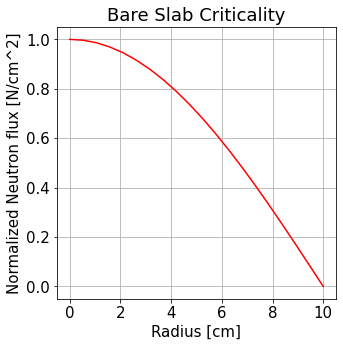

In [43]:
import pandas as pd

df = pd.read_csv('inputEigenProblem_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem_out.csv')
unormal=df2["u-normalized"]
fig = plt.figure(figsize=(5,5))
plt.plot(df["x"],df["u"]/unormal[1],"r-")

u_values=df["u"]/unormal[1]
plt.grid()

plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

plt.title("Bare Slab Criticality")
plt.show()



In [77]:

print(u_values)

0     1.000017e+00
1     9.966019e-01
2     9.863783e-01
3     9.694174e-01
4     9.458334e-01
5     9.157896e-01
6     8.794890e-01
7     8.371808e-01
8     7.891547e-01
9     7.357359e-01
10    6.772942e-01
11    6.142228e-01
12    5.469581e-01
13    4.759558e-01
14    4.017016e-01
15    3.247060e-01
16    2.454887e-01
17    1.645985e-01
18    8.258033e-02
19    7.096627e-09
Name: u, dtype: float64


#### [Two-Group Energy](#toc)<a id="twogroupenergy"></a>

In [162]:
!./neutron__transport-opt -i inputEigenProblem2g.hit



Framework Information:
MOOSE Version:           git commit 1d1b703aef on 2021-08-22
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Thu Apr 28 19:52:23 2022
Executable Timestamp:    Wed Apr 27 10:55:53 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   41
  Elems:                   20
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                42
  Num Local DOFs:          42
  Variables:               { "u1" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Execution Information:
  Executioner:             Eigenvalue
  Solver Mode:             Preconditioned JFNK


Postprocessor Values:
+----------------+----------------+----------------+
| time           | u-normalized   | u-normalized2  |
+----------------+------

    315 Linear |R| = 3.748684e+03
    316 Linear |R| = 3.748658e+03
    317 Linear |R| = 3.748600e+03
    318 Linear |R| = 3.748482e+03
    319 Linear |R| = 3.748467e+03
    320 Linear |R| = 3.748466e+03
    321 Linear |R| = 3.748364e+03
    322 Linear |R| = 3.747984e+03
    323 Linear |R| = 3.747915e+03
    324 Linear |R| = 3.747257e+03
    325 Linear |R| = 3.747125e+03
    326 Linear |R| = 3.746595e+03
    327 Linear |R| = 3.744162e+03
    328 Linear |R| = 3.743140e+03
    329 Linear |R| = 3.742896e+03
    330 Linear |R| = 3.724601e+03
    331 Linear |R| = 3.724601e+03
    332 Linear |R| = 3.724590e+03
    333 Linear |R| = 3.724584e+03
    334 Linear |R| = 3.724583e+03
    335 Linear |R| = 3.724575e+03
    336 Linear |R| = 3.724568e+03
    337 Linear |R| = 3.724567e+03
    338 Linear |R| = 3.724567e+03
    339 Linear |R| = 3.724566e+03
    340 Linear |R| = 3.724564e+03
    341 Linear |R| = 3.724564e+03
    342 Linear |R| = 3.724560e+03
    343 Linear |R| = 3.724558e+03
    344 Linear

    526 Linear |R| = 3.624748e+03
    527 Linear |R| = 3.624604e+03
    528 Linear |R| = 3.624548e+03
    529 Linear |R| = 3.624481e+03
    530 Linear |R| = 3.624289e+03
    531 Linear |R| = 3.624086e+03
    532 Linear |R| = 3.624086e+03
    533 Linear |R| = 3.623804e+03
    534 Linear |R| = 3.623711e+03
    535 Linear |R| = 3.619775e+03
    536 Linear |R| = 3.611428e+03
    537 Linear |R| = 3.611073e+03
    538 Linear |R| = 3.609822e+03
    539 Linear |R| = 3.608535e+03
    540 Linear |R| = 3.610152e+03
    541 Linear |R| = 3.610152e+03
    542 Linear |R| = 3.610152e+03
    543 Linear |R| = 3.610152e+03
    544 Linear |R| = 3.610151e+03
    545 Linear |R| = 3.610150e+03
    546 Linear |R| = 3.610149e+03
    547 Linear |R| = 3.610146e+03
    548 Linear |R| = 3.610144e+03
    549 Linear |R| = 3.610141e+03
    550 Linear |R| = 3.610138e+03
    551 Linear |R| = 3.610125e+03
    552 Linear |R| = 3.610102e+03
    553 Linear |R| = 3.610097e+03
    554 Linear |R| = 3.610084e+03
    555 Linear

    738 Linear |R| = 3.383849e+03
    739 Linear |R| = 3.383013e+03
    740 Linear |R| = 3.381383e+03
    741 Linear |R| = 3.378668e+03
    742 Linear |R| = 3.378074e+03
    743 Linear |R| = 3.377008e+03
    744 Linear |R| = 3.376602e+03
    745 Linear |R| = 3.375435e+03
    746 Linear |R| = 3.374979e+03
    747 Linear |R| = 3.374755e+03
    748 Linear |R| = 3.374607e+03
    749 Linear |R| = 3.364822e+03
    750 Linear |R| = 3.379332e+03
    751 Linear |R| = 3.379332e+03
    752 Linear |R| = 3.379319e+03
    753 Linear |R| = 3.379312e+03
    754 Linear |R| = 3.379297e+03
    755 Linear |R| = 3.379297e+03
    756 Linear |R| = 3.379271e+03
    757 Linear |R| = 3.379258e+03
    758 Linear |R| = 3.379258e+03
    759 Linear |R| = 3.379242e+03
    760 Linear |R| = 3.379228e+03
    761 Linear |R| = 3.379221e+03
    762 Linear |R| = 3.379188e+03
    763 Linear |R| = 3.379186e+03
    764 Linear |R| = 3.379099e+03
    765 Linear |R| = 3.379039e+03
    766 Linear |R| = 3.379015e+03
    767 Linear

    948 Linear |R| = 3.436814e+03
    949 Linear |R| = 3.433709e+03
    950 Linear |R| = 3.433516e+03
    951 Linear |R| = 3.433389e+03
    952 Linear |R| = 3.433386e+03
    953 Linear |R| = 3.433148e+03
    954 Linear |R| = 3.431413e+03
    955 Linear |R| = 3.430525e+03
    956 Linear |R| = 3.428148e+03
    957 Linear |R| = 3.426084e+03
    958 Linear |R| = 3.400151e+03
    959 Linear |R| = 3.369115e+03
    960 Linear |R| = 3.378491e+03
    961 Linear |R| = 3.378491e+03
    962 Linear |R| = 3.378491e+03
    963 Linear |R| = 3.378490e+03
    964 Linear |R| = 3.378468e+03
    965 Linear |R| = 3.378459e+03
    966 Linear |R| = 3.378454e+03
    967 Linear |R| = 3.378454e+03
    968 Linear |R| = 3.378441e+03
    969 Linear |R| = 3.378436e+03
    970 Linear |R| = 3.378431e+03
    971 Linear |R| = 3.378430e+03
    972 Linear |R| = 3.378427e+03
    973 Linear |R| = 3.378424e+03
    974 Linear |R| = 3.378421e+03
    975 Linear |R| = 3.378410e+03
    976 Linear |R| = 3.378406e+03
    977 Linear

   1144 Linear |R| = 3.355716e+03
   1145 Linear |R| = 3.355690e+03
   1146 Linear |R| = 3.355690e+03
   1147 Linear |R| = 3.355669e+03
   1148 Linear |R| = 3.355661e+03
   1149 Linear |R| = 3.355563e+03
   1150 Linear |R| = 3.355549e+03
   1151 Linear |R| = 3.355453e+03
   1152 Linear |R| = 3.355418e+03
   1153 Linear |R| = 3.355357e+03
   1154 Linear |R| = 3.355316e+03
   1155 Linear |R| = 3.355299e+03
   1156 Linear |R| = 3.355248e+03
   1157 Linear |R| = 3.355248e+03
   1158 Linear |R| = 3.354918e+03
   1159 Linear |R| = 3.354892e+03
   1160 Linear |R| = 3.354509e+03
   1161 Linear |R| = 3.353691e+03
   1162 Linear |R| = 3.353356e+03
   1163 Linear |R| = 3.353264e+03
   1164 Linear |R| = 3.353083e+03
   1165 Linear |R| = 3.352745e+03
   1166 Linear |R| = 3.352569e+03
   1167 Linear |R| = 3.351392e+03
   1168 Linear |R| = 3.351330e+03
   1169 Linear |R| = 3.345607e+03
   1170 Linear |R| = 3.355290e+03
   1171 Linear |R| = 3.355290e+03
   1172 Linear |R| = 3.355290e+03
   1173 Linear

   1352 Linear |R| = 3.332408e+03
   1353 Linear |R| = 3.332406e+03
   1354 Linear |R| = 3.332406e+03
   1355 Linear |R| = 3.332406e+03
   1356 Linear |R| = 3.332401e+03
   1357 Linear |R| = 3.332401e+03
   1358 Linear |R| = 3.332399e+03
   1359 Linear |R| = 3.332397e+03
   1360 Linear |R| = 3.332397e+03
   1361 Linear |R| = 3.332394e+03
   1362 Linear |R| = 3.332388e+03
   1363 Linear |R| = 3.332386e+03
   1364 Linear |R| = 3.332382e+03
   1365 Linear |R| = 3.332368e+03
   1366 Linear |R| = 3.332350e+03
   1367 Linear |R| = 3.332317e+03
   1368 Linear |R| = 3.332314e+03
   1369 Linear |R| = 3.332267e+03
   1370 Linear |R| = 3.332264e+03
   1371 Linear |R| = 3.332006e+03
   1372 Linear |R| = 3.331989e+03
   1373 Linear |R| = 3.331820e+03
   1374 Linear |R| = 3.331693e+03
   1375 Linear |R| = 3.331638e+03
   1376 Linear |R| = 3.331632e+03
   1377 Linear |R| = 3.331361e+03
   1378 Linear |R| = 3.328642e+03
   1379 Linear |R| = 3.327120e+03
   1380 Linear |R| = 3.332957e+03
   1381 Linear

   1563 Linear |R| = 3.324578e+03
   1564 Linear |R| = 3.324574e+03
   1565 Linear |R| = 3.324573e+03
   1566 Linear |R| = 3.324570e+03
   1567 Linear |R| = 3.324563e+03
   1568 Linear |R| = 3.324561e+03
   1569 Linear |R| = 3.324560e+03
   1570 Linear |R| = 3.324550e+03
   1571 Linear |R| = 3.324549e+03
   1572 Linear |R| = 3.324533e+03
   1573 Linear |R| = 3.324531e+03
   1574 Linear |R| = 3.324523e+03
   1575 Linear |R| = 3.324517e+03
   1576 Linear |R| = 3.324516e+03
   1577 Linear |R| = 3.324515e+03
   1578 Linear |R| = 3.324514e+03
   1579 Linear |R| = 3.324504e+03
   1580 Linear |R| = 3.324497e+03
   1581 Linear |R| = 3.324496e+03
   1582 Linear |R| = 3.324435e+03
   1583 Linear |R| = 3.324413e+03
   1584 Linear |R| = 3.324404e+03
   1585 Linear |R| = 3.324403e+03
   1586 Linear |R| = 3.324337e+03
   1587 Linear |R| = 3.324319e+03
   1588 Linear |R| = 3.324038e+03
   1589 Linear |R| = 3.323886e+03
   1590 Linear |R| = 3.330299e+03
   1591 Linear |R| = 3.330299e+03
   1592 Linear

   1771 Linear |R| = 3.317750e+03
   1772 Linear |R| = 3.317750e+03
   1773 Linear |R| = 3.317749e+03
   1774 Linear |R| = 3.317747e+03
   1775 Linear |R| = 3.317743e+03
   1776 Linear |R| = 3.317743e+03
   1777 Linear |R| = 3.317743e+03
   1778 Linear |R| = 3.317742e+03
   1779 Linear |R| = 3.317742e+03
   1780 Linear |R| = 3.317741e+03
   1781 Linear |R| = 3.317735e+03
   1782 Linear |R| = 3.317723e+03
   1783 Linear |R| = 3.317677e+03
   1784 Linear |R| = 3.317668e+03
   1785 Linear |R| = 3.317635e+03
   1786 Linear |R| = 3.317431e+03
   1787 Linear |R| = 3.317412e+03
   1788 Linear |R| = 3.317343e+03
   1789 Linear |R| = 3.317239e+03
   1790 Linear |R| = 3.317095e+03
   1791 Linear |R| = 3.316945e+03
   1792 Linear |R| = 3.316725e+03
   1793 Linear |R| = 3.316407e+03
   1794 Linear |R| = 3.316400e+03
   1795 Linear |R| = 3.315921e+03
   1796 Linear |R| = 3.315300e+03
   1797 Linear |R| = 3.314448e+03
   1798 Linear |R| = 3.313707e+03
   1799 Linear |R| = 3.313253e+03
   1800 Linear

   1976 Linear |R| = 3.304024e+03
   1977 Linear |R| = 3.303972e+03
   1978 Linear |R| = 3.302484e+03
   1979 Linear |R| = 3.301854e+03
   1980 Linear |R| = 3.310666e+03
   1981 Linear |R| = 3.310666e+03
   1982 Linear |R| = 3.310651e+03
   1983 Linear |R| = 3.310649e+03
   1984 Linear |R| = 3.310628e+03
   1985 Linear |R| = 3.310627e+03
   1986 Linear |R| = 3.310627e+03
   1987 Linear |R| = 3.310612e+03
   1988 Linear |R| = 3.310579e+03
   1989 Linear |R| = 3.310577e+03
   1990 Linear |R| = 3.310543e+03
   1991 Linear |R| = 3.310536e+03
   1992 Linear |R| = 3.310536e+03
   1993 Linear |R| = 3.310507e+03
   1994 Linear |R| = 3.310460e+03
   1995 Linear |R| = 3.310368e+03
   1996 Linear |R| = 3.310205e+03
   1997 Linear |R| = 3.310196e+03
   1998 Linear |R| = 3.309425e+03
   1999 Linear |R| = 3.309423e+03
   2000 Linear |R| = 3.309013e+03
   2001 Linear |R| = 3.309011e+03
   2002 Linear |R| = 3.308606e+03
   2003 Linear |R| = 3.307063e+03
   2004 Linear |R| = 3.306536e+03
   2005 Linear

   2185 Linear |R| = 3.295427e+03
   2186 Linear |R| = 3.294699e+03
   2187 Linear |R| = 3.294531e+03
   2188 Linear |R| = 3.294494e+03
   2189 Linear |R| = 3.293759e+03
   2190 Linear |R| = 3.293965e+03
   2191 Linear |R| = 3.293965e+03
   2192 Linear |R| = 3.293962e+03
   2193 Linear |R| = 3.293959e+03
   2194 Linear |R| = 3.293958e+03
   2195 Linear |R| = 3.293958e+03
   2196 Linear |R| = 3.293937e+03
   2197 Linear |R| = 3.293934e+03
   2198 Linear |R| = 3.293925e+03
   2199 Linear |R| = 3.293924e+03
   2200 Linear |R| = 3.293914e+03
   2201 Linear |R| = 3.293914e+03
   2202 Linear |R| = 3.293910e+03
   2203 Linear |R| = 3.293902e+03
   2204 Linear |R| = 3.293900e+03
   2205 Linear |R| = 3.293878e+03
   2206 Linear |R| = 3.293874e+03
   2207 Linear |R| = 3.293846e+03
   2208 Linear |R| = 3.293824e+03
   2209 Linear |R| = 3.293803e+03
   2210 Linear |R| = 3.293794e+03
   2211 Linear |R| = 3.293653e+03
   2212 Linear |R| = 3.293652e+03
   2213 Linear |R| = 3.293580e+03
   2214 Linear

   2394 Linear |R| = 3.287816e+03
   2395 Linear |R| = 3.287815e+03
   2396 Linear |R| = 3.287752e+03
   2397 Linear |R| = 3.287748e+03
   2398 Linear |R| = 3.287582e+03
   2399 Linear |R| = 3.287580e+03
   2400 Linear |R| = 3.297706e+03
   2401 Linear |R| = 3.297706e+03
   2402 Linear |R| = 3.297706e+03
   2403 Linear |R| = 3.297706e+03
   2404 Linear |R| = 3.297706e+03
   2405 Linear |R| = 3.297706e+03
   2406 Linear |R| = 3.297706e+03
   2407 Linear |R| = 3.297704e+03
   2408 Linear |R| = 3.297704e+03
   2409 Linear |R| = 3.297703e+03
   2410 Linear |R| = 3.297702e+03
   2411 Linear |R| = 3.297702e+03
   2412 Linear |R| = 3.297700e+03
   2413 Linear |R| = 3.297700e+03
   2414 Linear |R| = 3.297697e+03
   2415 Linear |R| = 3.297695e+03
   2416 Linear |R| = 3.297689e+03
   2417 Linear |R| = 3.297672e+03
   2418 Linear |R| = 3.297666e+03
   2419 Linear |R| = 3.297654e+03
   2420 Linear |R| = 3.297654e+03
   2421 Linear |R| = 3.297653e+03
   2422 Linear |R| = 3.297596e+03
   2423 Linear

   2601 Linear |R| = 3.268761e+03
   2602 Linear |R| = 3.268760e+03
   2603 Linear |R| = 3.268542e+03
   2604 Linear |R| = 3.268512e+03
   2605 Linear |R| = 3.268395e+03
   2606 Linear |R| = 3.268143e+03
   2607 Linear |R| = 3.267470e+03
   2608 Linear |R| = 3.267447e+03
   2609 Linear |R| = 3.266003e+03
   2610 Linear |R| = 3.264995e+03
   2611 Linear |R| = 3.264995e+03
   2612 Linear |R| = 3.264993e+03
   2613 Linear |R| = 3.264991e+03
   2614 Linear |R| = 3.264980e+03
   2615 Linear |R| = 3.264980e+03
   2616 Linear |R| = 3.264978e+03
   2617 Linear |R| = 3.264978e+03
   2618 Linear |R| = 3.264978e+03
   2619 Linear |R| = 3.264976e+03
   2620 Linear |R| = 3.264975e+03
   2621 Linear |R| = 3.264967e+03
   2622 Linear |R| = 3.264966e+03
   2623 Linear |R| = 3.264941e+03
   2624 Linear |R| = 3.264941e+03
   2625 Linear |R| = 3.264914e+03
   2626 Linear |R| = 3.264911e+03
   2627 Linear |R| = 3.264814e+03
   2628 Linear |R| = 3.264812e+03
   2629 Linear |R| = 3.264714e+03
   2630 Linear

   2810 Linear |R| = 3.261615e+03
   2811 Linear |R| = 3.261598e+03
   2812 Linear |R| = 3.261557e+03
   2813 Linear |R| = 3.261551e+03
   2814 Linear |R| = 3.261545e+03
   2815 Linear |R| = 3.261511e+03
   2816 Linear |R| = 3.261494e+03
   2817 Linear |R| = 3.261185e+03
   2818 Linear |R| = 3.261154e+03
   2819 Linear |R| = 3.261012e+03
   2820 Linear |R| = 3.258759e+03
   2821 Linear |R| = 3.258759e+03
   2822 Linear |R| = 3.258757e+03
   2823 Linear |R| = 3.258754e+03
   2824 Linear |R| = 3.258723e+03
   2825 Linear |R| = 3.258720e+03
   2826 Linear |R| = 3.258720e+03
   2827 Linear |R| = 3.258720e+03
   2828 Linear |R| = 3.258720e+03
   2829 Linear |R| = 3.258720e+03
   2830 Linear |R| = 3.258719e+03
   2831 Linear |R| = 3.258719e+03
   2832 Linear |R| = 3.258719e+03
   2833 Linear |R| = 3.258719e+03
   2834 Linear |R| = 3.258716e+03
   2835 Linear |R| = 3.258715e+03
   2836 Linear |R| = 3.258710e+03
   2837 Linear |R| = 3.258710e+03
   2838 Linear |R| = 3.258708e+03
   2839 Linear

   3015 Linear |R| = 3.252145e+03
   3016 Linear |R| = 3.252125e+03
   3017 Linear |R| = 3.252122e+03
   3018 Linear |R| = 3.252075e+03
   3019 Linear |R| = 3.252075e+03
   3020 Linear |R| = 3.252072e+03
   3021 Linear |R| = 3.252070e+03
   3022 Linear |R| = 3.252050e+03
   3023 Linear |R| = 3.251860e+03
   3024 Linear |R| = 3.251698e+03
   3025 Linear |R| = 3.251698e+03
   3026 Linear |R| = 3.251631e+03
   3027 Linear |R| = 3.251487e+03
   3028 Linear |R| = 3.251486e+03
   3029 Linear |R| = 3.251191e+03
   3030 Linear |R| = 3.258713e+03
   3031 Linear |R| = 3.258713e+03
   3032 Linear |R| = 3.258710e+03
   3033 Linear |R| = 3.258707e+03
   3034 Linear |R| = 3.258707e+03
   3035 Linear |R| = 3.258706e+03
   3036 Linear |R| = 3.258701e+03
   3037 Linear |R| = 3.258700e+03
   3038 Linear |R| = 3.258699e+03
   3039 Linear |R| = 3.258694e+03
   3040 Linear |R| = 3.258692e+03
   3041 Linear |R| = 3.258692e+03
   3042 Linear |R| = 3.258687e+03
   3043 Linear |R| = 3.258686e+03
   3044 Linear

   3224 Linear |R| = 3.249240e+03
   3225 Linear |R| = 3.249226e+03
   3226 Linear |R| = 3.249201e+03
   3227 Linear |R| = 3.249183e+03
   3228 Linear |R| = 3.249107e+03
   3229 Linear |R| = 3.249106e+03
   3230 Linear |R| = 3.249089e+03
   3231 Linear |R| = 3.249078e+03
   3232 Linear |R| = 3.249044e+03
   3233 Linear |R| = 3.249026e+03
   3234 Linear |R| = 3.249010e+03
   3235 Linear |R| = 3.248757e+03
   3236 Linear |R| = 3.248299e+03
   3237 Linear |R| = 3.247203e+03
   3238 Linear |R| = 3.247192e+03
   3239 Linear |R| = 3.247105e+03
   3240 Linear |R| = 3.246430e+03
   3241 Linear |R| = 3.246429e+03
   3242 Linear |R| = 3.246429e+03
   3243 Linear |R| = 3.246429e+03
   3244 Linear |R| = 3.246424e+03
   3245 Linear |R| = 3.246422e+03
   3246 Linear |R| = 3.246422e+03
   3247 Linear |R| = 3.246421e+03
   3248 Linear |R| = 3.246420e+03
   3249 Linear |R| = 3.246418e+03
   3250 Linear |R| = 3.246401e+03
   3251 Linear |R| = 3.246400e+03
   3252 Linear |R| = 3.246285e+03
   3253 Linear

   3432 Linear |R| = 3.246865e+03
   3433 Linear |R| = 3.246807e+03
   3434 Linear |R| = 3.246664e+03
   3435 Linear |R| = 3.246637e+03
   3436 Linear |R| = 3.246282e+03
   3437 Linear |R| = 3.246245e+03
   3438 Linear |R| = 3.245638e+03
   3439 Linear |R| = 3.245339e+03
   3440 Linear |R| = 3.245164e+03
   3441 Linear |R| = 3.245088e+03
   3442 Linear |R| = 3.243964e+03
   3443 Linear |R| = 3.243936e+03
   3444 Linear |R| = 3.243819e+03
   3445 Linear |R| = 3.243748e+03
   3446 Linear |R| = 3.243435e+03
   3447 Linear |R| = 3.243412e+03
   3448 Linear |R| = 3.243100e+03
   3449 Linear |R| = 3.242127e+03
   3450 Linear |R| = 3.236562e+03
   3451 Linear |R| = 3.236562e+03
   3452 Linear |R| = 3.236559e+03
   3453 Linear |R| = 3.236556e+03
   3454 Linear |R| = 3.236555e+03
   3455 Linear |R| = 3.236553e+03
   3456 Linear |R| = 3.236552e+03
   3457 Linear |R| = 3.236551e+03
   3458 Linear |R| = 3.236549e+03
   3459 Linear |R| = 3.236549e+03
   3460 Linear |R| = 3.236549e+03
   3461 Linear

   3634 Linear |R| = 3.259747e+03
   3635 Linear |R| = 3.259737e+03
   3636 Linear |R| = 3.259724e+03
   3637 Linear |R| = 3.259724e+03
   3638 Linear |R| = 3.259723e+03
   3639 Linear |R| = 3.259651e+03
   3640 Linear |R| = 3.259623e+03
   3641 Linear |R| = 3.259553e+03
   3642 Linear |R| = 3.259509e+03
   3643 Linear |R| = 3.259467e+03
   3644 Linear |R| = 3.259281e+03
   3645 Linear |R| = 3.259268e+03
   3646 Linear |R| = 3.259038e+03
   3647 Linear |R| = 3.259013e+03
   3648 Linear |R| = 3.258954e+03
   3649 Linear |R| = 3.258831e+03
   3650 Linear |R| = 3.258817e+03
   3651 Linear |R| = 3.258534e+03
   3652 Linear |R| = 3.258397e+03
   3653 Linear |R| = 3.257758e+03
   3654 Linear |R| = 3.257720e+03
   3655 Linear |R| = 3.257051e+03
   3656 Linear |R| = 3.254820e+03
   3657 Linear |R| = 3.254640e+03
   3658 Linear |R| = 3.250177e+03
   3659 Linear |R| = 3.247797e+03
   3660 Linear |R| = 3.250211e+03
   3661 Linear |R| = 3.250211e+03
   3662 Linear |R| = 3.250210e+03
   3663 Linear

   3830 Linear |R| = 3.254766e+03
   3831 Linear |R| = 3.254750e+03
   3832 Linear |R| = 3.254705e+03
   3833 Linear |R| = 3.254389e+03
   3834 Linear |R| = 3.253773e+03
   3835 Linear |R| = 3.253694e+03
   3836 Linear |R| = 3.253666e+03
   3837 Linear |R| = 3.253625e+03
   3838 Linear |R| = 3.253625e+03
   3839 Linear |R| = 3.253572e+03
   3840 Linear |R| = 3.240400e+03
   3841 Linear |R| = 3.240400e+03
   3842 Linear |R| = 3.240400e+03
   3843 Linear |R| = 3.240399e+03
   3844 Linear |R| = 3.240399e+03
   3845 Linear |R| = 3.240399e+03
   3846 Linear |R| = 3.240399e+03
   3847 Linear |R| = 3.240396e+03
   3848 Linear |R| = 3.240396e+03
   3849 Linear |R| = 3.240395e+03
   3850 Linear |R| = 3.240386e+03
   3851 Linear |R| = 3.240386e+03
   3852 Linear |R| = 3.240354e+03
   3853 Linear |R| = 3.240348e+03
   3854 Linear |R| = 3.240070e+03
   3855 Linear |R| = 3.239831e+03
   3856 Linear |R| = 3.239824e+03
   3857 Linear |R| = 3.239713e+03
   3858 Linear |R| = 3.239712e+03
   3859 Linear

   4036 Linear |R| = 3.233700e+03
   4037 Linear |R| = 3.233700e+03
   4038 Linear |R| = 3.233700e+03
   4039 Linear |R| = 3.233699e+03
   4040 Linear |R| = 3.233698e+03
   4041 Linear |R| = 3.233693e+03
   4042 Linear |R| = 3.233662e+03
   4043 Linear |R| = 3.233571e+03
   4044 Linear |R| = 3.233428e+03
   4045 Linear |R| = 3.232947e+03
   4046 Linear |R| = 3.232840e+03
   4047 Linear |R| = 3.232829e+03
   4048 Linear |R| = 3.232829e+03
   4049 Linear |R| = 3.232828e+03
   4050 Linear |R| = 3.244030e+03
   4051 Linear |R| = 3.244030e+03
   4052 Linear |R| = 3.244030e+03
   4053 Linear |R| = 3.244030e+03
   4054 Linear |R| = 3.244029e+03
   4055 Linear |R| = 3.244029e+03
   4056 Linear |R| = 3.244029e+03
   4057 Linear |R| = 3.244029e+03
   4058 Linear |R| = 3.244029e+03
   4059 Linear |R| = 3.244029e+03
   4060 Linear |R| = 3.244029e+03
   4061 Linear |R| = 3.244029e+03
   4062 Linear |R| = 3.244027e+03
   4063 Linear |R| = 3.244027e+03
   4064 Linear |R| = 3.244023e+03
   4065 Linear

   4243 Linear |R| = 3.246298e+03
   4244 Linear |R| = 3.246297e+03
   4245 Linear |R| = 3.246274e+03
   4246 Linear |R| = 3.246257e+03
   4247 Linear |R| = 3.246225e+03
   4248 Linear |R| = 3.246207e+03
   4249 Linear |R| = 3.246175e+03
   4250 Linear |R| = 3.246170e+03
   4251 Linear |R| = 3.246133e+03
   4252 Linear |R| = 3.245796e+03
   4253 Linear |R| = 3.245255e+03
   4254 Linear |R| = 3.245051e+03
   4255 Linear |R| = 3.244859e+03
   4256 Linear |R| = 3.244747e+03
   4257 Linear |R| = 3.243889e+03
   4258 Linear |R| = 3.243365e+03
   4259 Linear |R| = 3.243272e+03
   4260 Linear |R| = 3.225348e+03
   4261 Linear |R| = 3.225348e+03
   4262 Linear |R| = 3.225336e+03
   4263 Linear |R| = 3.225333e+03
   4264 Linear |R| = 3.225332e+03
   4265 Linear |R| = 3.225328e+03
   4266 Linear |R| = 3.225324e+03
   4267 Linear |R| = 3.225324e+03
   4268 Linear |R| = 3.225321e+03
   4269 Linear |R| = 3.225319e+03
   4270 Linear |R| = 3.225301e+03
   4271 Linear |R| = 3.225295e+03
   4272 Linear

   4448 Linear |R| = 3.242683e+03
   4449 Linear |R| = 3.242653e+03
   4450 Linear |R| = 3.242621e+03
   4451 Linear |R| = 3.242603e+03
   4452 Linear |R| = 3.242563e+03
   4453 Linear |R| = 3.242554e+03
   4454 Linear |R| = 3.242537e+03
   4455 Linear |R| = 3.242452e+03
   4456 Linear |R| = 3.242437e+03
   4457 Linear |R| = 3.242227e+03
   4458 Linear |R| = 3.242130e+03
   4459 Linear |R| = 3.241934e+03
   4460 Linear |R| = 3.241645e+03
   4461 Linear |R| = 3.241503e+03
   4462 Linear |R| = 3.241072e+03
   4463 Linear |R| = 3.239986e+03
   4464 Linear |R| = 3.239703e+03
   4465 Linear |R| = 3.239576e+03
   4466 Linear |R| = 3.239433e+03
   4467 Linear |R| = 3.239367e+03
   4468 Linear |R| = 3.236488e+03
   4469 Linear |R| = 3.236431e+03
   4470 Linear |R| = 3.227991e+03
   4471 Linear |R| = 3.227991e+03
   4472 Linear |R| = 3.227990e+03
   4473 Linear |R| = 3.227989e+03
   4474 Linear |R| = 3.227955e+03
   4475 Linear |R| = 3.227955e+03
   4476 Linear |R| = 3.227932e+03
   4477 Linear

   4656 Linear |R| = 3.226197e+03
   4657 Linear |R| = 3.226193e+03
   4658 Linear |R| = 3.226190e+03
   4659 Linear |R| = 3.226161e+03
   4660 Linear |R| = 3.226149e+03
   4661 Linear |R| = 3.226135e+03
   4662 Linear |R| = 3.226113e+03
   4663 Linear |R| = 3.226111e+03
   4664 Linear |R| = 3.226091e+03
   4665 Linear |R| = 3.226085e+03
   4666 Linear |R| = 3.226085e+03
   4667 Linear |R| = 3.226076e+03
   4668 Linear |R| = 3.226075e+03
   4669 Linear |R| = 3.226065e+03
   4670 Linear |R| = 3.226032e+03
   4671 Linear |R| = 3.225973e+03
   4672 Linear |R| = 3.225943e+03
   4673 Linear |R| = 3.225918e+03
   4674 Linear |R| = 3.225346e+03
   4675 Linear |R| = 3.225338e+03
   4676 Linear |R| = 3.225290e+03
   4677 Linear |R| = 3.225200e+03
   4678 Linear |R| = 3.224449e+03
   4679 Linear |R| = 3.223201e+03
   4680 Linear |R| = 3.230393e+03
   4681 Linear |R| = 3.230393e+03
   4682 Linear |R| = 3.230392e+03
   4683 Linear |R| = 3.230392e+03
   4684 Linear |R| = 3.230391e+03
   4685 Linear

   4861 Linear |R| = 3.224239e+03
   4862 Linear |R| = 3.224238e+03
   4863 Linear |R| = 3.224237e+03
   4864 Linear |R| = 3.224237e+03
   4865 Linear |R| = 3.224234e+03
   4866 Linear |R| = 3.224234e+03
   4867 Linear |R| = 3.224234e+03
   4868 Linear |R| = 3.224229e+03
   4869 Linear |R| = 3.224224e+03
   4870 Linear |R| = 3.224221e+03
   4871 Linear |R| = 3.224192e+03
   4872 Linear |R| = 3.224190e+03
   4873 Linear |R| = 3.224132e+03
   4874 Linear |R| = 3.224012e+03
   4875 Linear |R| = 3.224005e+03
   4876 Linear |R| = 3.223870e+03
   4877 Linear |R| = 3.223835e+03
   4878 Linear |R| = 3.223602e+03
   4879 Linear |R| = 3.223586e+03
   4880 Linear |R| = 3.223586e+03
   4881 Linear |R| = 3.223349e+03
   4882 Linear |R| = 3.223344e+03
   4883 Linear |R| = 3.223242e+03
   4884 Linear |R| = 3.223120e+03
   4885 Linear |R| = 3.222658e+03
   4886 Linear |R| = 3.222379e+03
   4887 Linear |R| = 3.222078e+03
   4888 Linear |R| = 3.221777e+03
   4889 Linear |R| = 3.221476e+03
   4890 Linear

   5072 Linear |R| = 3.219910e+03
   5073 Linear |R| = 3.219910e+03
   5074 Linear |R| = 3.219899e+03
   5075 Linear |R| = 3.219898e+03
   5076 Linear |R| = 3.219891e+03
   5077 Linear |R| = 3.219883e+03
   5078 Linear |R| = 3.219883e+03
   5079 Linear |R| = 3.219877e+03
   5080 Linear |R| = 3.219877e+03
   5081 Linear |R| = 3.219876e+03
   5082 Linear |R| = 3.219875e+03
   5083 Linear |R| = 3.219873e+03
   5084 Linear |R| = 3.219870e+03
   5085 Linear |R| = 3.219869e+03
   5086 Linear |R| = 3.219828e+03
   5087 Linear |R| = 3.219811e+03
   5088 Linear |R| = 3.219760e+03
   5089 Linear |R| = 3.219756e+03
   5090 Linear |R| = 3.219713e+03
   5091 Linear |R| = 3.219709e+03
   5092 Linear |R| = 3.219704e+03
   5093 Linear |R| = 3.219700e+03
   5094 Linear |R| = 3.219552e+03
   5095 Linear |R| = 3.218713e+03
   5096 Linear |R| = 3.218650e+03
   5097 Linear |R| = 3.218183e+03
   5098 Linear |R| = 3.217946e+03
   5099 Linear |R| = 3.217945e+03
   5100 Linear |R| = 3.243458e+03
   5101 Linear

   5275 Linear |R| = 3.245448e+03
   5276 Linear |R| = 3.244814e+03
   5277 Linear |R| = 3.244702e+03
   5278 Linear |R| = 3.244490e+03
   5279 Linear |R| = 3.244489e+03
   5280 Linear |R| = 3.228321e+03
   5281 Linear |R| = 3.228321e+03
   5282 Linear |R| = 3.228314e+03
   5283 Linear |R| = 3.228308e+03
   5284 Linear |R| = 3.228308e+03
   5285 Linear |R| = 3.228305e+03
   5286 Linear |R| = 3.228303e+03
   5287 Linear |R| = 3.228302e+03
   5288 Linear |R| = 3.228287e+03
   5289 Linear |R| = 3.228282e+03
   5290 Linear |R| = 3.228276e+03
   5291 Linear |R| = 3.228275e+03
   5292 Linear |R| = 3.228274e+03
   5293 Linear |R| = 3.228274e+03
   5294 Linear |R| = 3.228269e+03
   5295 Linear |R| = 3.228269e+03
   5296 Linear |R| = 3.228260e+03
   5297 Linear |R| = 3.228258e+03
   5298 Linear |R| = 3.228175e+03
   5299 Linear |R| = 3.228121e+03
   5300 Linear |R| = 3.228107e+03
   5301 Linear |R| = 3.228103e+03
   5302 Linear |R| = 3.227890e+03
   5303 Linear |R| = 3.227805e+03
   5304 Linear

   5485 Linear |R| = 3.229276e+03
   5486 Linear |R| = 3.227922e+03
   5487 Linear |R| = 3.226984e+03
   5488 Linear |R| = 3.225603e+03
   5489 Linear |R| = 3.225148e+03
   5490 Linear |R| = 3.222281e+03
   5491 Linear |R| = 3.222281e+03
   5492 Linear |R| = 3.222278e+03
   5493 Linear |R| = 3.222274e+03
   5494 Linear |R| = 3.222273e+03
   5495 Linear |R| = 3.222270e+03
   5496 Linear |R| = 3.222267e+03
   5497 Linear |R| = 3.222267e+03
   5498 Linear |R| = 3.222267e+03
   5499 Linear |R| = 3.222251e+03
   5500 Linear |R| = 3.222250e+03
   5501 Linear |R| = 3.222230e+03
   5502 Linear |R| = 3.222208e+03
   5503 Linear |R| = 3.222196e+03
   5504 Linear |R| = 3.222127e+03
   5505 Linear |R| = 3.222127e+03
   5506 Linear |R| = 3.222122e+03
   5507 Linear |R| = 3.222094e+03
   5508 Linear |R| = 3.222060e+03
   5509 Linear |R| = 3.222059e+03
   5510 Linear |R| = 3.222046e+03
   5511 Linear |R| = 3.221977e+03
   5512 Linear |R| = 3.221964e+03
   5513 Linear |R| = 3.221964e+03
   5514 Linear

   5683 Linear |R| = 3.245849e+03
   5684 Linear |R| = 3.245575e+03
   5685 Linear |R| = 3.245534e+03
   5686 Linear |R| = 3.245443e+03
   5687 Linear |R| = 3.245422e+03
   5688 Linear |R| = 3.245382e+03
   5689 Linear |R| = 3.245260e+03
   5690 Linear |R| = 3.245260e+03
   5691 Linear |R| = 3.245068e+03
   5692 Linear |R| = 3.245066e+03
   5693 Linear |R| = 3.244954e+03
   5694 Linear |R| = 3.244535e+03
   5695 Linear |R| = 3.243941e+03
   5696 Linear |R| = 3.243939e+03
   5697 Linear |R| = 3.239690e+03
   5698 Linear |R| = 3.237198e+03
   5699 Linear |R| = 3.237198e+03
   5700 Linear |R| = 3.227899e+03
   5701 Linear |R| = 3.227899e+03
   5702 Linear |R| = 3.227898e+03
   5703 Linear |R| = 3.227898e+03
   5704 Linear |R| = 3.227897e+03
   5705 Linear |R| = 3.227897e+03
   5706 Linear |R| = 3.227895e+03
   5707 Linear |R| = 3.227889e+03
   5708 Linear |R| = 3.227881e+03
   5709 Linear |R| = 3.227873e+03
   5710 Linear |R| = 3.227858e+03
   5711 Linear |R| = 3.227851e+03
   5712 Linear

   5892 Linear |R| = 3.207135e+03
   5893 Linear |R| = 3.207133e+03
   5894 Linear |R| = 3.206992e+03
   5895 Linear |R| = 3.206933e+03
   5896 Linear |R| = 3.206859e+03
   5897 Linear |R| = 3.206602e+03
   5898 Linear |R| = 3.206589e+03
   5899 Linear |R| = 3.206319e+03
   5900 Linear |R| = 3.206318e+03
   5901 Linear |R| = 3.206005e+03
   5902 Linear |R| = 3.205865e+03
   5903 Linear |R| = 3.205477e+03
   5904 Linear |R| = 3.204423e+03
   5905 Linear |R| = 3.204182e+03
   5906 Linear |R| = 3.203551e+03
   5907 Linear |R| = 3.203307e+03
   5908 Linear |R| = 3.203259e+03
   5909 Linear |R| = 3.202797e+03
   5910 Linear |R| = 3.210276e+03
   5911 Linear |R| = 3.210276e+03
   5912 Linear |R| = 3.210268e+03
   5913 Linear |R| = 3.210252e+03
   5914 Linear |R| = 3.210247e+03
   5915 Linear |R| = 3.210244e+03
   5916 Linear |R| = 3.210242e+03
   5917 Linear |R| = 3.210241e+03
   5918 Linear |R| = 3.210213e+03
   5919 Linear |R| = 3.210209e+03
   5920 Linear |R| = 3.210201e+03
   5921 Linear

   6099 Linear |R| = 3.205646e+03
   6100 Linear |R| = 3.205352e+03
   6101 Linear |R| = 3.205196e+03
   6102 Linear |R| = 3.205091e+03
   6103 Linear |R| = 3.205082e+03
   6104 Linear |R| = 3.205046e+03
   6105 Linear |R| = 3.204877e+03
   6106 Linear |R| = 3.204578e+03
   6107 Linear |R| = 3.204391e+03
   6108 Linear |R| = 3.203177e+03
   6109 Linear |R| = 3.203098e+03
   6110 Linear |R| = 3.202926e+03
   6111 Linear |R| = 3.202386e+03
   6112 Linear |R| = 3.202265e+03
   6113 Linear |R| = 3.199965e+03
   6114 Linear |R| = 3.199687e+03
   6115 Linear |R| = 3.199167e+03
   6116 Linear |R| = 3.199088e+03
   6117 Linear |R| = 3.198571e+03
   6118 Linear |R| = 3.197427e+03
   6119 Linear |R| = 3.196962e+03
   6120 Linear |R| = 3.207642e+03
   6121 Linear |R| = 3.207642e+03
   6122 Linear |R| = 3.207638e+03
   6123 Linear |R| = 3.207635e+03
   6124 Linear |R| = 3.207619e+03
   6125 Linear |R| = 3.207617e+03
   6126 Linear |R| = 3.207605e+03
   6127 Linear |R| = 3.207602e+03
   6128 Linear

   6305 Linear |R| = 3.204901e+03
   6306 Linear |R| = 3.204892e+03
   6307 Linear |R| = 3.204881e+03
   6308 Linear |R| = 3.204880e+03
   6309 Linear |R| = 3.204877e+03
   6310 Linear |R| = 3.204871e+03
   6311 Linear |R| = 3.204870e+03
   6312 Linear |R| = 3.204862e+03
   6313 Linear |R| = 3.204861e+03
   6314 Linear |R| = 3.204847e+03
   6315 Linear |R| = 3.204846e+03
   6316 Linear |R| = 3.204842e+03
   6317 Linear |R| = 3.204836e+03
   6318 Linear |R| = 3.204835e+03
   6319 Linear |R| = 3.204831e+03
   6320 Linear |R| = 3.204823e+03
   6321 Linear |R| = 3.204818e+03
   6322 Linear |R| = 3.204798e+03
   6323 Linear |R| = 3.204795e+03
   6324 Linear |R| = 3.204771e+03
   6325 Linear |R| = 3.204767e+03
   6326 Linear |R| = 3.204757e+03
   6327 Linear |R| = 3.204654e+03
   6328 Linear |R| = 3.204534e+03
   6329 Linear |R| = 3.204417e+03
   6330 Linear |R| = 3.214062e+03
   6331 Linear |R| = 3.214062e+03
   6332 Linear |R| = 3.214062e+03
   6333 Linear |R| = 3.214062e+03
   6334 Linear

   6517 Linear |R| = 3.177418e+03
   6518 Linear |R| = 3.177409e+03
   6519 Linear |R| = 3.177407e+03
   6520 Linear |R| = 3.177395e+03
   6521 Linear |R| = 3.177395e+03
   6522 Linear |R| = 3.177388e+03
   6523 Linear |R| = 3.177375e+03
   6524 Linear |R| = 3.177369e+03
   6525 Linear |R| = 3.177328e+03
   6526 Linear |R| = 3.177328e+03
   6527 Linear |R| = 3.177263e+03
   6528 Linear |R| = 3.177216e+03
   6529 Linear |R| = 3.177151e+03
   6530 Linear |R| = 3.177144e+03
   6531 Linear |R| = 3.177095e+03
   6532 Linear |R| = 3.176854e+03
   6533 Linear |R| = 3.176706e+03
   6534 Linear |R| = 3.176634e+03
   6535 Linear |R| = 3.176455e+03
   6536 Linear |R| = 3.176248e+03
   6537 Linear |R| = 3.176219e+03
   6538 Linear |R| = 3.175929e+03
   6539 Linear |R| = 3.175905e+03
   6540 Linear |R| = 3.188906e+03
   6541 Linear |R| = 3.188906e+03
   6542 Linear |R| = 3.188904e+03
   6543 Linear |R| = 3.188903e+03
   6544 Linear |R| = 3.188902e+03
   6545 Linear |R| = 3.188902e+03
   6546 Linear

   6719 Linear |R| = 3.193303e+03
   6720 Linear |R| = 3.178606e+03
   6721 Linear |R| = 3.178606e+03
   6722 Linear |R| = 3.178606e+03
   6723 Linear |R| = 3.178606e+03
   6724 Linear |R| = 3.178600e+03
   6725 Linear |R| = 3.178600e+03
   6726 Linear |R| = 3.178598e+03
   6727 Linear |R| = 3.178596e+03
   6728 Linear |R| = 3.178590e+03
   6729 Linear |R| = 3.178589e+03
   6730 Linear |R| = 3.178569e+03
   6731 Linear |R| = 3.178565e+03
   6732 Linear |R| = 3.178563e+03
   6733 Linear |R| = 3.178539e+03
   6734 Linear |R| = 3.178537e+03
   6735 Linear |R| = 3.178536e+03
   6736 Linear |R| = 3.178506e+03
   6737 Linear |R| = 3.178495e+03
   6738 Linear |R| = 3.178472e+03
   6739 Linear |R| = 3.178462e+03
   6740 Linear |R| = 3.178460e+03
   6741 Linear |R| = 3.178436e+03
   6742 Linear |R| = 3.178428e+03
   6743 Linear |R| = 3.178428e+03
   6744 Linear |R| = 3.178420e+03
   6745 Linear |R| = 3.178401e+03
   6746 Linear |R| = 3.178386e+03
   6747 Linear |R| = 3.178043e+03
   6748 Linear

   6923 Linear |R| = 3.168498e+03
   6924 Linear |R| = 3.168497e+03
   6925 Linear |R| = 3.167739e+03
   6926 Linear |R| = 3.167654e+03
   6927 Linear |R| = 3.167297e+03
   6928 Linear |R| = 3.166082e+03
   6929 Linear |R| = 3.165798e+03
   6930 Linear |R| = 3.178832e+03
   6931 Linear |R| = 3.178832e+03
   6932 Linear |R| = 3.178819e+03
   6933 Linear |R| = 3.178799e+03
   6934 Linear |R| = 3.178795e+03
   6935 Linear |R| = 3.178789e+03
   6936 Linear |R| = 3.178739e+03
   6937 Linear |R| = 3.178729e+03
   6938 Linear |R| = 3.178725e+03
   6939 Linear |R| = 3.178661e+03
   6940 Linear |R| = 3.178652e+03
   6941 Linear |R| = 3.178610e+03
   6942 Linear |R| = 3.178610e+03
   6943 Linear |R| = 3.178543e+03
   6944 Linear |R| = 3.178528e+03
   6945 Linear |R| = 3.178525e+03
   6946 Linear |R| = 3.178510e+03
   6947 Linear |R| = 3.178510e+03
   6948 Linear |R| = 3.178510e+03
   6949 Linear |R| = 3.178509e+03
   6950 Linear |R| = 3.178420e+03
   6951 Linear |R| = 3.178303e+03
   6952 Linear

   7134 Linear |R| = 3.176614e+03
   7135 Linear |R| = 3.176371e+03
   7136 Linear |R| = 3.176185e+03
   7137 Linear |R| = 3.176087e+03
   7138 Linear |R| = 3.176026e+03
   7139 Linear |R| = 3.175710e+03
   7140 Linear |R| = 3.176409e+03
   7141 Linear |R| = 3.176409e+03
   7142 Linear |R| = 3.176395e+03
   7143 Linear |R| = 3.176378e+03
   7144 Linear |R| = 3.176378e+03
   7145 Linear |R| = 3.176378e+03
   7146 Linear |R| = 3.176368e+03
   7147 Linear |R| = 3.176358e+03
   7148 Linear |R| = 3.176358e+03
   7149 Linear |R| = 3.176311e+03
   7150 Linear |R| = 3.176311e+03
   7151 Linear |R| = 3.176283e+03
   7152 Linear |R| = 3.176271e+03
   7153 Linear |R| = 3.176260e+03
   7154 Linear |R| = 3.176259e+03
   7155 Linear |R| = 3.176258e+03
   7156 Linear |R| = 3.176258e+03
   7157 Linear |R| = 3.176258e+03
   7158 Linear |R| = 3.176258e+03
   7159 Linear |R| = 3.176253e+03
   7160 Linear |R| = 3.176214e+03
   7161 Linear |R| = 3.176210e+03
   7162 Linear |R| = 3.176203e+03
   7163 Linear

   7342 Linear |R| = 3.169432e+03
   7343 Linear |R| = 3.169396e+03
   7344 Linear |R| = 3.169295e+03
   7345 Linear |R| = 3.158173e+03
   7346 Linear |R| = 3.157929e+03
   7347 Linear |R| = 3.155102e+03
   7348 Linear |R| = 3.155099e+03
   7349 Linear |R| = 3.155090e+03
   7350 Linear |R| = 3.172383e+03
   7351 Linear |R| = 3.172383e+03
   7352 Linear |R| = 3.172377e+03
   7353 Linear |R| = 3.172376e+03
   7354 Linear |R| = 3.172374e+03
   7355 Linear |R| = 3.172367e+03
   7356 Linear |R| = 3.172362e+03
   7357 Linear |R| = 3.172359e+03
   7358 Linear |R| = 3.172355e+03
   7359 Linear |R| = 3.172318e+03
   7360 Linear |R| = 3.172292e+03
   7361 Linear |R| = 3.172267e+03
   7362 Linear |R| = 3.172112e+03
   7363 Linear |R| = 3.172112e+03
   7364 Linear |R| = 3.172047e+03
   7365 Linear |R| = 3.171999e+03
   7366 Linear |R| = 3.171903e+03
   7367 Linear |R| = 3.171771e+03
   7368 Linear |R| = 3.171656e+03
   7369 Linear |R| = 3.171297e+03
   7370 Linear |R| = 3.171111e+03
   7371 Linear

   7550 Linear |R| = 3.176851e+03
   7551 Linear |R| = 3.176585e+03
   7552 Linear |R| = 3.176292e+03
   7553 Linear |R| = 3.175762e+03
   7554 Linear |R| = 3.174809e+03
   7555 Linear |R| = 3.170592e+03
   7556 Linear |R| = 3.170579e+03
   7557 Linear |R| = 3.170516e+03
   7558 Linear |R| = 3.170259e+03
   7559 Linear |R| = 3.169867e+03
   7560 Linear |R| = 3.166356e+03
   7561 Linear |R| = 3.166356e+03
   7562 Linear |R| = 3.166350e+03
   7563 Linear |R| = 3.166347e+03
   7564 Linear |R| = 3.166341e+03
   7565 Linear |R| = 3.166340e+03
   7566 Linear |R| = 3.166333e+03
   7567 Linear |R| = 3.166328e+03
   7568 Linear |R| = 3.166312e+03
   7569 Linear |R| = 3.166298e+03
   7570 Linear |R| = 3.166290e+03
   7571 Linear |R| = 3.166289e+03
   7572 Linear |R| = 3.166289e+03
   7573 Linear |R| = 3.166289e+03
   7574 Linear |R| = 3.166287e+03
   7575 Linear |R| = 3.166287e+03
   7576 Linear |R| = 3.166239e+03
   7577 Linear |R| = 3.166237e+03
   7578 Linear |R| = 3.166235e+03
   7579 Linear

   7761 Linear |R| = 3.163606e+03
   7762 Linear |R| = 3.163537e+03
   7763 Linear |R| = 3.163280e+03
   7764 Linear |R| = 3.163076e+03
   7765 Linear |R| = 3.162991e+03
   7766 Linear |R| = 3.162173e+03
   7767 Linear |R| = 3.162170e+03
   7768 Linear |R| = 3.161263e+03
   7769 Linear |R| = 3.161183e+03
   7770 Linear |R| = 3.167885e+03
   7771 Linear |R| = 3.167885e+03
   7772 Linear |R| = 3.167856e+03
   7773 Linear |R| = 3.167826e+03
   7774 Linear |R| = 3.167821e+03
   7775 Linear |R| = 3.167806e+03
   7776 Linear |R| = 3.167800e+03
   7777 Linear |R| = 3.167800e+03
   7778 Linear |R| = 3.167800e+03
   7779 Linear |R| = 3.167799e+03
   7780 Linear |R| = 3.167795e+03
   7781 Linear |R| = 3.167792e+03
   7782 Linear |R| = 3.167774e+03
   7783 Linear |R| = 3.167772e+03
   7784 Linear |R| = 3.167761e+03
   7785 Linear |R| = 3.167759e+03
   7786 Linear |R| = 3.167759e+03
   7787 Linear |R| = 3.167743e+03
   7788 Linear |R| = 3.167733e+03
   7789 Linear |R| = 3.167709e+03
   7790 Linear

   7970 Linear |R| = 3.160991e+03
   7971 Linear |R| = 3.160958e+03
   7972 Linear |R| = 3.160943e+03
   7973 Linear |R| = 3.160684e+03
   7974 Linear |R| = 3.160554e+03
   7975 Linear |R| = 3.160505e+03
   7976 Linear |R| = 3.160438e+03
   7977 Linear |R| = 3.160420e+03
   7978 Linear |R| = 3.159465e+03
   7979 Linear |R| = 3.156594e+03
   7980 Linear |R| = 3.167806e+03
   7981 Linear |R| = 3.167806e+03
   7982 Linear |R| = 3.167797e+03
   7983 Linear |R| = 3.167796e+03
   7984 Linear |R| = 3.167787e+03
   7985 Linear |R| = 3.167786e+03
   7986 Linear |R| = 3.167750e+03
   7987 Linear |R| = 3.167747e+03
   7988 Linear |R| = 3.167734e+03
   7989 Linear |R| = 3.167691e+03
   7990 Linear |R| = 3.167602e+03
   7991 Linear |R| = 3.167591e+03
   7992 Linear |R| = 3.167516e+03
   7993 Linear |R| = 3.167515e+03
   7994 Linear |R| = 3.167489e+03
   7995 Linear |R| = 3.167486e+03
   7996 Linear |R| = 3.167439e+03
   7997 Linear |R| = 3.167422e+03
   7998 Linear |R| = 3.167403e+03
   7999 Linear

   8177 Linear |R| = 3.161311e+03
   8178 Linear |R| = 3.160534e+03
   8179 Linear |R| = 3.160415e+03
   8180 Linear |R| = 3.159851e+03
   8181 Linear |R| = 3.159193e+03
   8182 Linear |R| = 3.159089e+03
   8183 Linear |R| = 3.156483e+03
   8184 Linear |R| = 3.156012e+03
   8185 Linear |R| = 3.154544e+03
   8186 Linear |R| = 3.153969e+03
   8187 Linear |R| = 3.152813e+03
   8188 Linear |R| = 3.152519e+03
   8189 Linear |R| = 3.152315e+03
   8190 Linear |R| = 3.162832e+03
   8191 Linear |R| = 3.162832e+03
   8192 Linear |R| = 3.162807e+03
   8193 Linear |R| = 3.162761e+03
   8194 Linear |R| = 3.162757e+03
   8195 Linear |R| = 3.162755e+03
   8196 Linear |R| = 3.162681e+03
   8197 Linear |R| = 3.162680e+03
   8198 Linear |R| = 3.162680e+03
   8199 Linear |R| = 3.162676e+03
   8200 Linear |R| = 3.162675e+03
   8201 Linear |R| = 3.162670e+03
   8202 Linear |R| = 3.162662e+03
   8203 Linear |R| = 3.162646e+03
   8204 Linear |R| = 3.162623e+03
   8205 Linear |R| = 3.162417e+03
   8206 Linear

   8388 Linear |R| = 3.163684e+03
   8389 Linear |R| = 3.163669e+03
   8390 Linear |R| = 3.163618e+03
   8391 Linear |R| = 3.163550e+03
   8392 Linear |R| = 3.163467e+03
   8393 Linear |R| = 3.163439e+03
   8394 Linear |R| = 3.163399e+03
   8395 Linear |R| = 3.163395e+03
   8396 Linear |R| = 3.162989e+03
   8397 Linear |R| = 3.161902e+03
   8398 Linear |R| = 3.161894e+03
   8399 Linear |R| = 3.161409e+03
   8400 Linear |R| = 3.164957e+03
   8401 Linear |R| = 3.164957e+03
   8402 Linear |R| = 3.164949e+03
   8403 Linear |R| = 3.164935e+03
   8404 Linear |R| = 3.164931e+03
   8405 Linear |R| = 3.164930e+03
   8406 Linear |R| = 3.164922e+03
   8407 Linear |R| = 3.164922e+03
   8408 Linear |R| = 3.164922e+03
   8409 Linear |R| = 3.164911e+03
   8410 Linear |R| = 3.164905e+03
   8411 Linear |R| = 3.164902e+03
   8412 Linear |R| = 3.164902e+03
   8413 Linear |R| = 3.164895e+03
   8414 Linear |R| = 3.164877e+03
   8415 Linear |R| = 3.164861e+03
   8416 Linear |R| = 3.164861e+03
   8417 Linear

   8599 Linear |R| = 3.161356e+03
   8600 Linear |R| = 3.161291e+03
   8601 Linear |R| = 3.161225e+03
   8602 Linear |R| = 3.161219e+03
   8603 Linear |R| = 3.159471e+03
   8604 Linear |R| = 3.158843e+03
   8605 Linear |R| = 3.158596e+03
   8606 Linear |R| = 3.157646e+03
   8607 Linear |R| = 3.157645e+03
   8608 Linear |R| = 3.156152e+03
   8609 Linear |R| = 3.156091e+03
   8610 Linear |R| = 3.155621e+03
   8611 Linear |R| = 3.155621e+03
   8612 Linear |R| = 3.155604e+03
   8613 Linear |R| = 3.155577e+03
   8614 Linear |R| = 3.155570e+03
   8615 Linear |R| = 3.155566e+03
   8616 Linear |R| = 3.155559e+03
   8617 Linear |R| = 3.155556e+03
   8618 Linear |R| = 3.155538e+03
   8619 Linear |R| = 3.155533e+03
   8620 Linear |R| = 3.155523e+03
   8621 Linear |R| = 3.155519e+03
   8622 Linear |R| = 3.155507e+03
   8623 Linear |R| = 3.155506e+03
   8624 Linear |R| = 3.155490e+03
   8625 Linear |R| = 3.155490e+03
   8626 Linear |R| = 3.155480e+03
   8627 Linear |R| = 3.155479e+03
   8628 Linear

   8810 Linear |R| = 3.150009e+03
   8811 Linear |R| = 3.150008e+03
   8812 Linear |R| = 3.150004e+03
   8813 Linear |R| = 3.149988e+03
   8814 Linear |R| = 3.149988e+03
   8815 Linear |R| = 3.149987e+03
   8816 Linear |R| = 3.149982e+03
   8817 Linear |R| = 3.149853e+03
   8818 Linear |R| = 3.149497e+03
   8819 Linear |R| = 3.149357e+03
   8820 Linear |R| = 3.148611e+03
   8821 Linear |R| = 3.148611e+03
   8822 Linear |R| = 3.148609e+03
   8823 Linear |R| = 3.148608e+03
   8824 Linear |R| = 3.148607e+03
   8825 Linear |R| = 3.148597e+03
   8826 Linear |R| = 3.148594e+03
   8827 Linear |R| = 3.148587e+03
   8828 Linear |R| = 3.148586e+03
   8829 Linear |R| = 3.148586e+03
   8830 Linear |R| = 3.148579e+03
   8831 Linear |R| = 3.148578e+03
   8832 Linear |R| = 3.148575e+03
   8833 Linear |R| = 3.148575e+03
   8834 Linear |R| = 3.148551e+03
   8835 Linear |R| = 3.148548e+03
   8836 Linear |R| = 3.148526e+03
   8837 Linear |R| = 3.148523e+03
   8838 Linear |R| = 3.148386e+03
   8839 Linear

   9022 Linear |R| = 3.163427e+03
   9023 Linear |R| = 3.163374e+03
   9024 Linear |R| = 3.163356e+03
   9025 Linear |R| = 3.162682e+03
   9026 Linear |R| = 3.162333e+03
   9027 Linear |R| = 3.161376e+03
   9028 Linear |R| = 3.161361e+03
   9029 Linear |R| = 3.161336e+03
   9030 Linear |R| = 3.160001e+03
   9031 Linear |R| = 3.160001e+03
   9032 Linear |R| = 3.160000e+03
   9033 Linear |R| = 3.159999e+03
   9034 Linear |R| = 3.159999e+03
   9035 Linear |R| = 3.159999e+03
   9036 Linear |R| = 3.159999e+03
   9037 Linear |R| = 3.159999e+03
   9038 Linear |R| = 3.159996e+03
   9039 Linear |R| = 3.159996e+03
   9040 Linear |R| = 3.159981e+03
   9041 Linear |R| = 3.159981e+03
   9042 Linear |R| = 3.159977e+03
   9043 Linear |R| = 3.159975e+03
   9044 Linear |R| = 3.159975e+03
   9045 Linear |R| = 3.159974e+03
   9046 Linear |R| = 3.159973e+03
   9047 Linear |R| = 3.159970e+03
   9048 Linear |R| = 3.159968e+03
   9049 Linear |R| = 3.159966e+03
   9050 Linear |R| = 3.159963e+03
   9051 Linear

   9236 Linear |R| = 3.144116e+03
   9237 Linear |R| = 3.143771e+03
   9238 Linear |R| = 3.143767e+03
   9239 Linear |R| = 3.143761e+03
   9240 Linear |R| = 3.150554e+03
   9241 Linear |R| = 3.150554e+03
   9242 Linear |R| = 3.150553e+03
   9243 Linear |R| = 3.150552e+03
   9244 Linear |R| = 3.150547e+03
   9245 Linear |R| = 3.150539e+03
   9246 Linear |R| = 3.150538e+03
   9247 Linear |R| = 3.150534e+03
   9248 Linear |R| = 3.150534e+03
   9249 Linear |R| = 3.150532e+03
   9250 Linear |R| = 3.150532e+03
   9251 Linear |R| = 3.150530e+03
   9252 Linear |R| = 3.150512e+03
   9253 Linear |R| = 3.150512e+03
   9254 Linear |R| = 3.150509e+03
   9255 Linear |R| = 3.150509e+03
   9256 Linear |R| = 3.150502e+03
   9257 Linear |R| = 3.150498e+03
   9258 Linear |R| = 3.150471e+03
   9259 Linear |R| = 3.150459e+03
   9260 Linear |R| = 3.150447e+03
   9261 Linear |R| = 3.150447e+03
   9262 Linear |R| = 3.150446e+03
   9263 Linear |R| = 3.150438e+03
   9264 Linear |R| = 3.150417e+03
   9265 Linear

   9446 Linear |R| = 3.140856e+03
   9447 Linear |R| = 3.140786e+03
   9448 Linear |R| = 3.140490e+03
   9449 Linear |R| = 3.139599e+03
   9450 Linear |R| = 3.139507e+03
   9451 Linear |R| = 3.139507e+03
   9452 Linear |R| = 3.139442e+03
   9453 Linear |R| = 3.139413e+03
   9454 Linear |R| = 3.139127e+03
   9455 Linear |R| = 3.139084e+03
   9456 Linear |R| = 3.139080e+03
   9457 Linear |R| = 3.139062e+03
   9458 Linear |R| = 3.139040e+03
   9459 Linear |R| = 3.139030e+03
   9460 Linear |R| = 3.139029e+03
   9461 Linear |R| = 3.139025e+03
   9462 Linear |R| = 3.139020e+03
   9463 Linear |R| = 3.139019e+03
   9464 Linear |R| = 3.139016e+03
   9465 Linear |R| = 3.139016e+03
   9466 Linear |R| = 3.139010e+03
   9467 Linear |R| = 3.138983e+03
   9468 Linear |R| = 3.138980e+03
   9469 Linear |R| = 3.138959e+03
   9470 Linear |R| = 3.138914e+03
   9471 Linear |R| = 3.138887e+03
   9472 Linear |R| = 3.138830e+03
   9473 Linear |R| = 3.138682e+03
   9474 Linear |R| = 3.138660e+03
   9475 Linear

   9654 Linear |R| = 3.121068e+03
   9655 Linear |R| = 3.121060e+03
   9656 Linear |R| = 3.121017e+03
   9657 Linear |R| = 3.120954e+03
   9658 Linear |R| = 3.120288e+03
   9659 Linear |R| = 3.119908e+03
   9660 Linear |R| = 3.129767e+03
   9661 Linear |R| = 3.129767e+03
   9662 Linear |R| = 3.129766e+03
   9663 Linear |R| = 3.129765e+03
   9664 Linear |R| = 3.129765e+03
   9665 Linear |R| = 3.129765e+03
   9666 Linear |R| = 3.129763e+03
   9667 Linear |R| = 3.129763e+03
   9668 Linear |R| = 3.129761e+03
   9669 Linear |R| = 3.129760e+03
   9670 Linear |R| = 3.129756e+03
   9671 Linear |R| = 3.129756e+03
   9672 Linear |R| = 3.129755e+03
   9673 Linear |R| = 3.129753e+03
   9674 Linear |R| = 3.129752e+03
   9675 Linear |R| = 3.129750e+03
   9676 Linear |R| = 3.129726e+03
   9677 Linear |R| = 3.129726e+03
   9678 Linear |R| = 3.129721e+03
   9679 Linear |R| = 3.129703e+03
   9680 Linear |R| = 3.129696e+03
   9681 Linear |R| = 3.129679e+03
   9682 Linear |R| = 3.129617e+03
   9683 Linear

   9863 Linear |R| = 3.142664e+03
   9864 Linear |R| = 3.142440e+03
   9865 Linear |R| = 3.142438e+03
   9866 Linear |R| = 3.142417e+03
   9867 Linear |R| = 3.141753e+03
   9868 Linear |R| = 3.141751e+03
   9869 Linear |R| = 3.141727e+03
   9870 Linear |R| = 3.141169e+03
   9871 Linear |R| = 3.141169e+03
   9872 Linear |R| = 3.141169e+03
   9873 Linear |R| = 3.141168e+03
   9874 Linear |R| = 3.141157e+03
   9875 Linear |R| = 3.141156e+03
   9876 Linear |R| = 3.141149e+03
   9877 Linear |R| = 3.141092e+03
   9878 Linear |R| = 3.141091e+03
   9879 Linear |R| = 3.141089e+03
   9880 Linear |R| = 3.141078e+03
   9881 Linear |R| = 3.141077e+03
   9882 Linear |R| = 3.141062e+03
   9883 Linear |R| = 3.141059e+03
   9884 Linear |R| = 3.141043e+03
   9885 Linear |R| = 3.141017e+03
   9886 Linear |R| = 3.141017e+03
   9887 Linear |R| = 3.140954e+03
   9888 Linear |R| = 3.140942e+03
   9889 Linear |R| = 3.140782e+03
   9890 Linear |R| = 3.140692e+03
   9891 Linear |R| = 3.140562e+03
   9892 Linear

      2 Linear |R| = 3.946912e+03
      3 Linear |R| = 3.586295e+03
      4 Linear |R| = 2.534995e+03
      5 Linear |R| = 2.449298e+03
      6 Linear |R| = 2.438925e+03
      7 Linear |R| = 2.382850e+03
      8 Linear |R| = 2.250392e+03
      9 Linear |R| = 2.247824e+03
     10 Linear |R| = 1.575208e+03
     11 Linear |R| = 1.568000e+03
     12 Linear |R| = 1.417924e+03
     13 Linear |R| = 1.099508e+03
     14 Linear |R| = 1.057800e+03
     15 Linear |R| = 7.641236e+02
     16 Linear |R| = 6.723912e+02
     17 Linear |R| = 5.678097e+02
     18 Linear |R| = 4.067198e+02
     19 Linear |R| = 3.275752e+02
     20 Linear |R| = 1.928981e+02
     21 Linear |R| = 1.700535e+02
     22 Linear |R| = 8.432970e+01
     23 Linear |R| = 8.266128e+01
     24 Linear |R| = 4.730510e+01
     25 Linear |R| = 4.120373e+01
     26 Linear |R| = 3.024897e+01
 3 Nonlinear |R| = 4.100192e+03
 Iteration 3 eigenvalue = 1.3337124620
      0 Linear |R| = 4.100192e+03
      1 Linear |R| = 4.099983e+03
      2 Lin

     74 Linear |R| = 1.400072e+02
     75 Linear |R| = 1.393744e+02
     76 Linear |R| = 1.386990e+02
     77 Linear |R| = 1.379566e+02
     78 Linear |R| = 1.356283e+02
     79 Linear |R| = 1.354639e+02
     80 Linear |R| = 1.344955e+02
     81 Linear |R| = 1.308384e+02
     82 Linear |R| = 1.289819e+02
     83 Linear |R| = 1.289789e+02
     84 Linear |R| = 1.187789e+02
     85 Linear |R| = 1.179951e+02
     86 Linear |R| = 1.177073e+02
     87 Linear |R| = 1.024126e+02
     88 Linear |R| = 1.010398e+02
     89 Linear |R| = 9.737889e+01
     90 Linear |R| = 9.757882e+01
     91 Linear |R| = 9.757703e+01
     92 Linear |R| = 9.734920e+01
     93 Linear |R| = 9.722751e+01
     94 Linear |R| = 9.703082e+01
     95 Linear |R| = 9.691296e+01
     96 Linear |R| = 9.658163e+01
     97 Linear |R| = 9.657015e+01
     98 Linear |R| = 9.647132e+01
     99 Linear |R| = 9.646268e+01
    100 Linear |R| = 9.643591e+01
    101 Linear |R| = 9.642273e+01
    102 Linear |R| = 9.641634e+01
    103 Linear

    Linear solve did not converge due to DIVERGED_BREAKDOWN iterations 60
  Nonlinear solve did not converge due to DIVERGED_LINEAR_SOLVE iterations 6


*** ERROR ***
The following error occurred in the object "MOOSE Problem", of type "EigenProblem".

Number of converged eigenvalues 0 but you required eigenvalue 0

Stack frames: 15
0: libMesh::print_trace(std::ostream&)
1: moose::internal::mooseErrorRaw(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)
2: callMooseErrorRaw(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >&, MooseApp*)
3: /home/anthonyb08/projects/moose/framework/libmoose-opt.so.0(+0x117d81c) [0x7f1667a3081c]
4: EigenProblem::postScaleEigenVector()
5: EigenProblem::solve()
6: FEProblemSolve::solve()
7: FixedPointSolve::solveStep(double&, double&, std::set<unsigned long, std::less<unsigned long>, std::allocator<unsigned long> > con

In [142]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem2g_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]






k=[v[0]*chi[0]*sigma_f[0]/(lam+sigma_a[0]-sigma_12),
   v[1]*chi[1]*sigma_f[1]/(lam+sigma_a[1]+sigma_12) ] 

print('Multiplicity factor for group-1 = ',k[0])
print('Multiplicity factor for group-2 = ',k[1])

Multiplicity factor for group-1 =  0   -0.390548
Name: eigen_values_real, dtype: float64
Multiplicity factor for group-2 =  0    0.238338
Name: eigen_values_real, dtype: float64


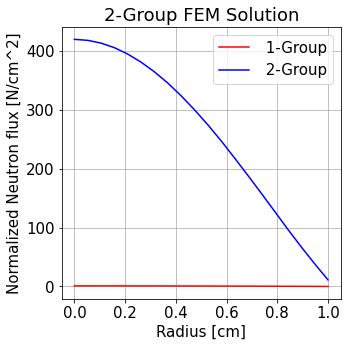

In [143]:
import pandas as pd
df = pd.read_csv('inputEigenProblem2g_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem2g_out.csv')
unormal=df2["u-normalized"]
unormal2=df2["u-normalized2"]
fig = plt.figure(figsize=(5,5))

plt.plot(df["x"],df["u1"]/unormal[1],"r-",label=" 1-Group")
plt.plot(df["x"],df["u2"]/unormal[1],"b-",label=" 2-Group")
#plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.title("2-Group FEM Solution")

plt.show()

In [98]:
#!rm output2G*.csv
#!./neutron__transport-opt -i input2G.hit



Framework Information:
MOOSE Version:           git commit 1d1b703aef on 2021-08-22
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Wed Apr 27 10:01:28 2022
Executable Timestamp:    Wed Apr 27 09:50:35 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   20001
  Elems:                   10000
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                40002
  Num Local DOFs:          40002
  Variables:               { "u1" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             NEWTON
  PETSc Preconditioner:    lu 
  MOOSE Preconditioner:    FDP



*** Warning ***
/home/anthonyb08/projects/neutron__transport/input2G.hit:11: unused parameter

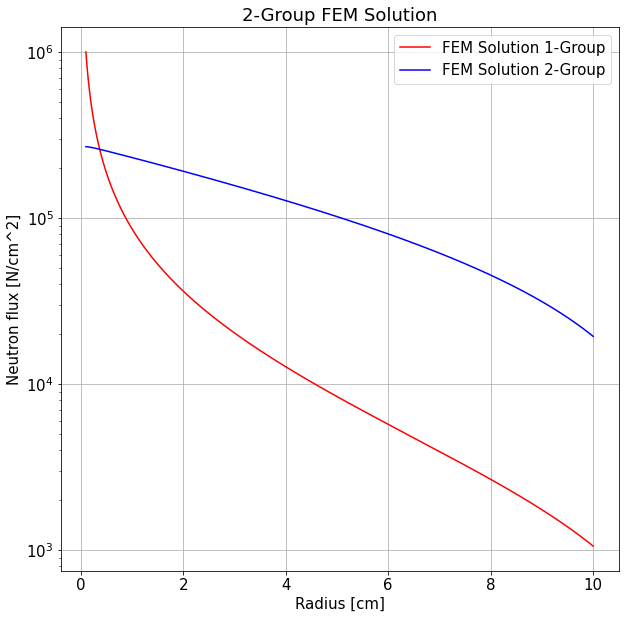

In [39]:
import pandas as pd
df = pd.read_csv('output2G_x-data_0002.csv')
fig = plt.figure(figsize=(10,10))
plt.plot(df["x"],df["u1"],"r-",label="FEM Solution 1-Group")
plt.plot(df["x"],df["u2"],"b-",label="FEM Solution 2-Group")
plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.title("2-Group FEM Solution")
plt.show()

## [FDM Approach](#toc)<a id="appFDM"></a>

### [Discretization](#toc)<a id="setupFDM"></a> 

For the discretization of the NDE a central approximation  is utilized, where for its respected differential 



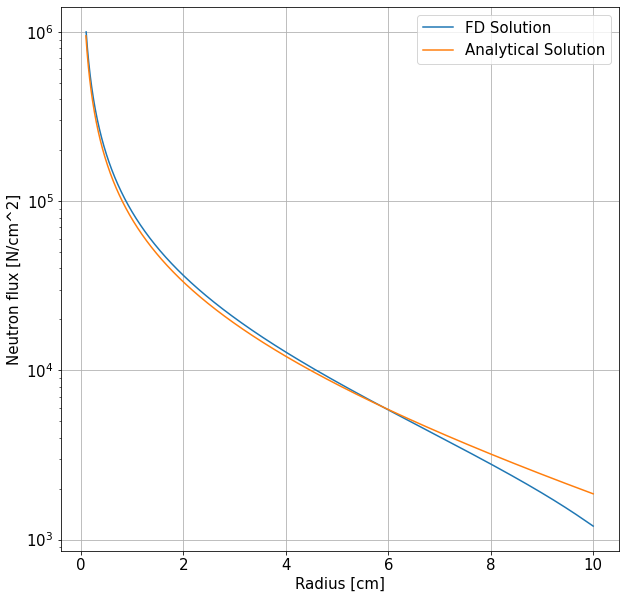

In [18]:
So = 1e6
N = 2000
rn = 10
r0 = 0.1
phi0 = So
alpha = 1

sigma_s = 0.022
D=0.87

h = (rn-r0)/(N+1)
r = np.arange(r0+h, rn, h)

A = np.zeros((N,N))
B = np.zeros(N)

A[0,0] = -sigma_s/D * h**2 - 2
A[0,1] = 1 + (h/(r0))
B[0] = -phi0 * (1-h/r0)

for i in range(1,N-1):
    A[i,i-1] = (1-(h/r[i]))
    A[i,i] = -sigma_s/D * h**2 - 2
    A[i,i+1] = 1 + (h/r[i])
    B[i] = 0

A[-1,-1] = (-h * alpha - 2 - h**2 * alpha/rn - sigma_s * h**2 / D)
A[-1,-2] = 1 + 1+h/rn-h/rn
B[-1] = 0

L = np.sqrt(D/sigma_s)

group1 = np.linalg.solve(A , B)
group1 = np.concatenate((np.array([phi0]),group1,np.array([group1[-1]])))

r = np.concatenate((np.array([r0]),r,np.array([rn])))


x = np.linspace(0.1-h,10,N)
y = So/(4*np.pi * x * D)*np.exp(-x/L)

fig = plt.figure(figsize=(10,10))
plt.plot(r,group1,label="FD Solution")
plt.plot(x,y,label="Analytical Solution")
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("AnalyticalFDSolution.png",dpi=300)
plt.show()

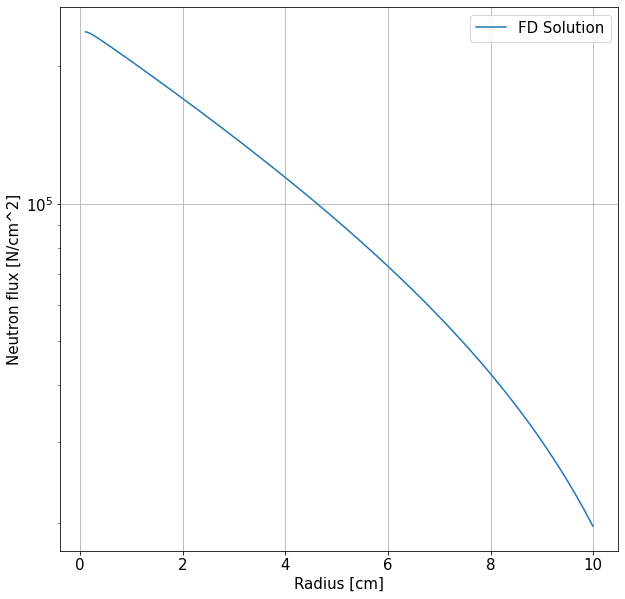

In [19]:
#Two group Finite Difference Method
So = 1e6
N = 2000
rn = 10
r0 = 0.1
phi0 = So
alpha = 1
sigma_1=0.022
sigma_2 = 0.022
sigma_12=0.87

D=0.87
L1 = np.sqrt(D/sigma_1)
h = (rn-r0)/(N+1)
r = np.arange(r0+h, rn, h)

A = np.zeros((N,N))
B = np.zeros(N)

A[0,0] = -sigma_2/D * h**2 - 2
A[0,1] = 2
B[0] = -sigma_12*h**2*group1[0]
#*So*np.exp(-r0/L1)/(4*np.pi*r0*D)

for i in range(1,N-1):
    A[i,i-1] = (1-(h/r[i]))
    A[i,i] = -sigma_2/D * h**2 - 2
    A[i,i+1] = 1 + (h/r[i])
    B[i] = -sigma_12*h**2*group1[i]
    #So*np.exp(-r[i]/L1)/(4*np.pi*r[i]*D)

A[-1,-1] = (-h * alpha - 2 - h**2 * alpha/rn - sigma_2 * h**2 / D)
A[-1,-2] = 1 + 1+h/rn-h/rn
B[-1] = -sigma_12*h**2*group1[-1]
#So*np.exp(-rn/L1)/(4*np.pi*rn*D)

L = np.sqrt(D/sigma_1)

group2 = np.linalg.solve(A , B)

#group2 = np.concatenate((np.array([phi0]),group2,np.array([group1[-1]])))
#r = np.concatenate((np.array([r0]),r,np.array([rn])))


x = np.linspace(0.1-h,10,N)
y = So/(4*np.pi * x * D)*np.exp(-x/L)

fig = plt.figure(figsize=(10,10))
plt.plot(r,group2,label="FD Solution")
#plt.plot(x,y,label="Analytical Solution")
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("AnalyticalFDSolution.png",dpi=300)
plt.show()

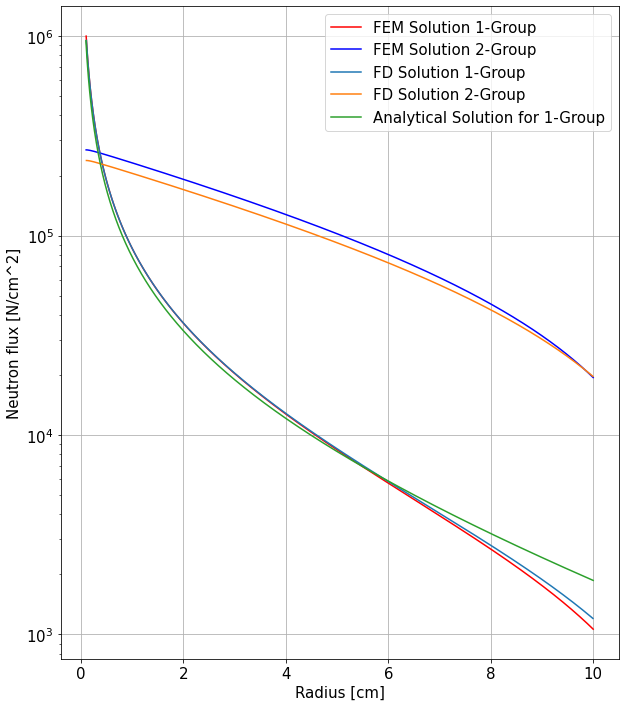

In [20]:
fig = plt.figure(figsize=(10,12))
plt.plot(df["x"],df["u1"],"r-",label="FEM Solution 1-Group")
plt.plot(df["x"],df["u2"],"b-",label="FEM Solution 2-Group")

plt.plot(r,group1[1:-1],label="FD Solution 1-Group")

#newely added
plt.plot(r,group2,label="FD Solution 2-Group")

plt.plot(x,y,label="Analytical Solution for 1-Group")
plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.savefig("Analytical_FD_FEM_Sols.png",dpi=300)
plt.show()

## [Results and Analysis](#toc)<a id="ranalysis"></a>